<a href="https://colab.research.google.com/github/evanshlom/pyspark_ml_web_app/blob/main/PySpark_ML_Hackathon_Sprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

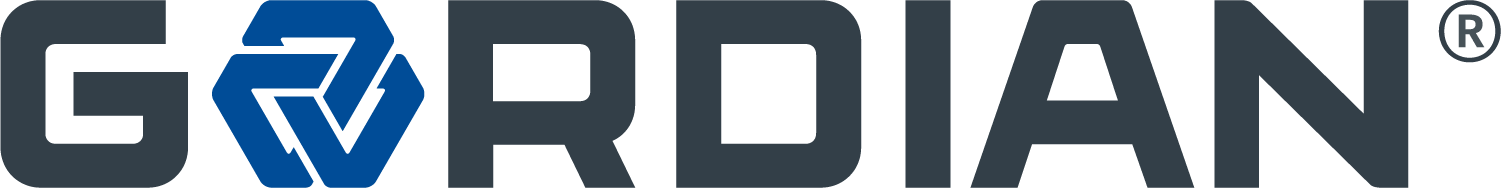

# train.py

In [ ]:
#@title Welcome to the Carbon Neutral Date Model! PYSPARK VERSION

#@markdown Table Of Contents:

#@markdown 1.)  LOAD: Load anonymous dataset (values were randomized for privacy)

#@markdown 2.)  PREPARE: Preprocess dataset

#@markdown 3.)  MODEL: Train and Test Regressor

#@markdown 4.)  SAVE: Pickle model

#@markdown Please contact Evan Shlom with any feedback or questions at eshlom@fandm.edu or via the LinkedIn page for Innovative Operations at https://www.linkedin.com/company/innovativeoperations/

#Filename = None #@param {type:"raw"}
#Filepath = None #@param {type:"raw"}

#@title

from google.colab import files
uploaded = files.upload()

#print(raw_input)
#print(raw_input2)

Saving sustainability.csv to sustainability.csv


Import File

***NEED TO EDIT THE PIPELINE FOR NET ZERO TEMPLATE 0.3.0 INSTEAD OF VXN 0.2.0

In [ ]:
#1
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 41.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1570a198049c8a8e8a9bfe3a11c06f905812183056c270fa6fa73b785c95e8f6
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
#2
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("PySpark Deployed Machine Learning with Unit Testing")\
        .master("local[*]")\
        .getOrCreate()

In [ ]:
import io
# rdd used to ingest data
# df could span entire pipeline
rdd = spark.read.csv("sustainability.csv", header=True).rdd

In [ ]:
# Persist RDD --- run unit test with these two persist methods as separate user-defined functions in a class, and unit test base as other class, with actual unit test in a third class with the two unit test functions
from pyspark.storagelevel import StorageLevel

# persist without serialization
rdd_serialize = rdd
rdd_serialize.persist(StorageLevel.DISK_ONLY)
####!!!! add unittest1 around this
rdd_serialize.unpersist()

# persist serialized
rdd_unserialize = rdd
rdd_unserialize.persist(StorageLevel.MEMORY_AND_DISK)
####!!!!! add unittest2 around this
rdd_unserialize.unpersist()

MapPartitionsRDD[14] at javaToPython at NativeMethodAccessorImpl.java:0

In [ ]:

name = ['Evan', 'Shlom']
test = ['Evan', 'test1','test2'] 




In [ ]:
class Class():
  def function(name, test):
    for i in name:
      for j in test:
        if i==j:
          return True
        else:
          return False

In [ ]:
for i in name:
  for j in test:
    if i==j:
      print("True")
    else:
      print("False")

True
False
False
False
False
False


In [ ]:
# inspect number of rows per institution_name
# throwaway
rdd.countByKey().items()

dict_items([('a', 6), ('b', 11), ('c', 9), ('d', 14), ('e', 8), ('f', 13), ('g', 10), ('h', 14), ('i', 15), ('j', 18), ('k', 16), ('l', 9), ('m', 17), ('n', 9), ('o', 15), ('p', 8), ('q', 16), ('r', 6), ('s', 9), ('t', 14), ('u', 18), ('v', 7)])

In [ ]:
# inspect first row of data in rdd
# throwaway
rdd.first()

Row(institution_name='a', Fiscal Year='2017', timestep='15', reverse_timestep='4', EUI-Adjusted Floor Space='248,942', gsf='248942', Weighted Campus User='416', fte_per_gsf='0.00167', Maintained Acres='0', Total Enrollment (FTE)2='298', Faculty (FTE)3='90', Staff (FTE)4='68', E-Grid Pre-2006='WECC California', E-Grid='WECC California', Scope 1 Emissions='840.0128467', Scope 2 Emissions='429.2013956', Scope 3 Emissions='555.3030901', Gross Emissions='1824.517332', Net Emissions='1,824.52', net_mtcde_per_gsf='0.00733', Stationary Emissions='584.2693621', Fleet Emissions='255.6980763', Refrigerant Emissions='0', Agricultural Emissions='0.045408263', Purchased Electric Emissions='429.2013956', Purchased Steam Emissions='0', Purchased Chilled Water Emissions='0', Student Community Emissions='13.6495915', Employee Commuting Emissions='106.1943118', Other Travel Emissions='141.8034551', Waste Emissions='258.94792', Wasterwater  Emissions='5.095961665', Paper Emissions='10.6547454', T&D Losses

In [ ]:
# convert rdd to df
# df for preprocessing
df = rdd.toDF()

# change type to float or int for feature and output cols
from pyspark.sql.types import DecimalType, IntegerType
decimal = DecimalType(precision=20, scale=5)
df = df \
      .withColumn("timestep",
                  df["timestep"]
                  .cast(IntegerType()))     \
      .withColumn("fte_per_gsf",
                   df["fte_per_gsf"]
                   .cast(decimal))    \
      .withColumn("net_mtcde_per_gsf",
                   df["net_mtcde_per_gsf"]
                   .cast(decimal))

df.printSchema()
df.show(truncate=False)

root
 |-- institution_name: string (nullable = true)
 |-- Fiscal Year: string (nullable = true)
 |-- timestep: integer (nullable = true)
 |-- reverse_timestep: string (nullable = true)
 |-- EUI-Adjusted Floor Space: string (nullable = true)
 |-- gsf: string (nullable = true)
 |-- Weighted Campus User: string (nullable = true)
 |-- fte_per_gsf: decimal(20,5) (nullable = true)
 |-- Maintained Acres: string (nullable = true)
 |-- Total Enrollment (FTE)2: string (nullable = true)
 |-- Faculty (FTE)3: string (nullable = true)
 |-- Staff (FTE)4: string (nullable = true)
 |-- E-Grid Pre-2006: string (nullable = true)
 |-- E-Grid: string (nullable = true)
 |-- Scope 1 Emissions: string (nullable = true)
 |-- Scope 2 Emissions: string (nullable = true)
 |-- Scope 3 Emissions: string (nullable = true)
 |-- Gross Emissions: string (nullable = true)
 |-- Net Emissions: string (nullable = true)
 |-- net_mtcde_per_gsf: decimal(20,5) (nullable = true)
 |-- Stationary Emissions: string (nullable = tru

In [ ]:
# throwaway - ignore this kernel
# Define features
feature_cols = [
            "timestep",
            "fte_per_gsf"
]          
X = df.select(feature_cols)
# Define target
y = df.select("net_mtcde_per_gsf")

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
            "timestep",
            "fte_per_gsf"
]
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol="feature_vector")
df = assembler.transform(df)
df.show()

+----------------+-----------+--------+----------------+------------------------+------+--------------------+-----------+----------------+-----------------------+--------------+------------+---------------+--------------------+-----------------+-----------------+-----------------+---------------+-------------+-----------------+--------------------+---------------+---------------------+----------------------+----------------------------+-------------------------+---------------------------------+---------------------------+----------------------------+----------------------+---------------+----------------------+---------------+--------------------+----------------+-----------------+---------+---------+-------+-----+------+--------------+
|institution_name|Fiscal Year|timestep|reverse_timestep|EUI-Adjusted Floor Space|   gsf|Weighted Campus User|fte_per_gsf|Maintained Acres|Total Enrollment (FTE)2|Faculty (FTE)3|Staff (FTE)4|E-Grid Pre-2006|              E-Grid|Scope 1 Emissions|Scope 2

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed=0)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 186
Test Dataset Count: 76


In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="feature_vector",
                           labelCol="net_mtcde_per_gsf",
                           maxDepth=5,
                           maxBins=1000)
rf.setSeed(0)
rfModel = rf.fit(train)

In [ ]:
# infer output for test vectors
# automatically add inferences col "prediction" to test df
predictions_test = rfModel.transform(test)

predictions_test.select("feature_vector", "net_mtcde_per_gsf", "prediction").show(25)

#calc mean squared error and evaluate, consider cross val, k fold val

+--------------+-----------------+--------------------+
|feature_vector|net_mtcde_per_gsf|          prediction|
+--------------+-----------------+--------------------+
|[14.0,0.00167]|          0.00644|0.007891433872905432|
|[18.0,0.00173]|          0.00601|0.007549695851077...|
|[10.0,0.00113]|          0.00511|0.007064230483022611|
|[14.0,0.00655]|          0.01606|0.023200471346015095|
|[15.0,0.00644]|          0.01342|0.021103293240093236|
| [4.0,0.00397]|          0.01773| 0.01738335622412008|
| [5.0,0.00451]|          0.01497|0.016992710808270677|
| [6.0,0.00443]|          0.01449|0.014311072196342303|
| [9.0,0.00432]|          0.01354| 0.01138694609310614|
|[12.0,0.00473]|          0.01095|0.015451013374911022|
|[13.0,0.00539]|          0.01101| 0.01600861586408851|
|[15.0,0.00508]|          0.00967|0.015927005465597478|
|[10.0,0.00248]|          0.00976|0.010507178241045039|
|  [8.0,0.0056]|          0.01409|0.013740696931869304|
| [9.0,0.00556]|          0.01389|0.013213568143

In [ ]:
# train model to be saved for app, training using all data (wouldnt do it this way if I wasnt in a rush making a starter prototype)
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="feature_vector",
                           labelCol="net_mtcde_per_gsf",
                           maxDepth=5,
                           maxBins=1000)
rf.setSeed(0)
rfModel = rf.fit(df)

In [ ]:
# use this in app to return outputs to user, using user's data
predictions = rfModel.transform(test)

In [ ]:
from google.colab import drive
drive.mount('/content/')
#drive.mount('/content/drive/')

ValueError: ignored

In [ ]:
# save model to path - debug 
rfModel.write().overwrite().save("/content/inference_rfmodel")
#rf.save("/content/drive/My Drive/x/rfModel")

In [ ]:
# save model using Joblib - debug
from joblib import dump
dump(rfModel, 'Inference_rfModel.joblib')

# inference.py

In [ ]:
from google.colab import files
uploaded_inf = files.upload()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("PySpark Deployed Machine Learning with Unit Testing")\
        .master("local[*]")\
        .getOrCreate()

In [ ]:
rdd = spark.read.csv("sustainability_inference.csv", header=True).rdd

In [ ]:
# Persist RDD --- run unit test with these two persist methods as separate user-defined functions in a class, and unit test base as other class, with actual unit test in a third class with the two unit test functions
from pyspark.storagelevel import StorageLevel

# persist without serialization
rdd_serialize = rdd
rdd_serialize.persist(StorageLevel.DISK_ONLY)
####!!!! add unittest1 around this
rdd_serialize.unpersist()

# persist serialized
rdd_unserialize = rdd
rdd_unserialize.persist(StorageLevel.MEMORY_AND_DISK)
####!!!!! add unittest2 around this
rdd_unserialize.unpersist()

In [ ]:
# convert rdd to df
# df for preprocessing
df = rdd.toDF()

# change type to float or int for feature and output cols
from pyspark.sql.types import DecimalType, IntegerType
decimal = DecimalType(precision=20, scale=5)
df = df \
      .withColumn("timestep",
                  df["timestep"]
                  .cast(IntegerType()))     \
      .withColumn("fte_per_gsf",
                   df["fte_per_gsf"]
                   .cast(decimal))    \
      .withColumn("net_mtcde_per_gsf",
                   df["net_mtcde_per_gsf"]
                   .cast(decimal))

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
            "timestep",
            "fte_per_gsf"
]
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol="feature_vector")
df = assembler.transform(df)
df.show()

In [ ]:
# load saved model file
from joblib import load
rfModel_loaded = load("/content/Inference_rfModel.joblib")

In [ ]:
# load saved model file
import joblib
joblib.load("/content/Inference_rfModel.joblib")

In [ ]:
predictions_test = rfModel.transform(test)

predictions_test.select("feature_vector", "net_mtcde_per_gsf", "prediction").show(25)

In [ ]:
# end

In [ ]:
# end

In [ ]:
# end

In [ ]:
# appendix:

In [ ]:
# appendix:

In [ ]:
# appendix:

In [ ]:
# appendix kernel (throwaway)

#3
from pyspark.sql import DataFrameReader
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType

# lazy evaluation
# user-defined schema to optimize Spark by causing less jobs to run ("inferSchema would cause 2nd job to run)
# False means that the schema rejects null values (those samples are rejected from the DataFrame)
csvSchema = StructType([StructField("institution_name", StringType(), True)],
                       [StructField("timestep", IntegerType(), True)],
                       [StructField("fte_per_gsf", DecimalType(precision=20,scale=5), True)],
                       [StructField("net_mtcde_per_gsf", DecimalType(precision=20,scale=5), True)],
                       [StructField("gsf", DecimalType(precision=20,scale=5), True)])

df = DataFrameReader.format("csv").schema(csvSchema).load(io.BytesIO(uploaded))

In [ ]:
# appendix kernel (throwaway)

import pandas as pd
import io

filename = next(iter(uploaded))

#(..., index_col='id')
dataset = pd.read_csv(io.BytesIO(uploaded['{}'.format(filename)]), skiprows=0)

df = dataset[['institution_name', 'timestep', 'fte_per_gsf', 'net_mtcde_per_gsf', 'gsf']].astype({
    'institution_name' : 'str',
    'timestep' : 'int',
    'fte_per_gsf' : 'float',
    'net_mtcde_per_gsf' : 'float',
    'gsf' : 'float'
})

In [ ]:
df = df.astype({
    
})

In [ ]:
display(df)

In [ ]:
# Define features
feature_cols = [
            'timestep',
            'fte_per_gsf'
]          
X = df[feature_cols]
# Define target
y = df.net_mtcde_per_gsf

In [ ]:
from sklearn.linear_model import LinearRegression

# Define Model
reg = LinearRegression()

reg.fit(X, y)

In [ ]:
from joblib import dump
dump(reg, 'Inference_reg.joblib')

# inference.py

In [ ]:
from google.colab import files
uploaded_inf = files.upload()

In [ ]:
filename_inf = next(iter(uploaded_inf))

#(..., index_col='id')
dataset_inf = pd.read_csv(io.BytesIO(uploaded_inf['{}'.format(filename_inf)]), skiprows=0)

df_inf = dataset_inf[['timestep', 'fte_per_gsf', 'net_mtcde_per_gsf', 'gsf']].astype({
    'timestep' : 'int',
    'fte_per_gsf' : 'float',
    'net_mtcde_per_gsf' : 'float',
    'gsf' : 'float'
})

In [ ]:
# Define features
feature_cols = [
            'timestep',
            'fte_per_gsf'
]          
X_inf = df_inf[feature_cols]
# Define target
y_inf = df_inf.net_mtcde_per_gsf

In [ ]:
from joblib import load
lin_reg = load('Inference_reg.joblib')

In [ ]:
print("Lin reg prediction:")

inference = lin_reg.predict(X_inf)
print(inference)

# de-normalize y inference to get total mtcde
# multiply (mtcde/gsf) by gsf
inf_total = inference * df_inf.gsf

print(inf_total)

In [ ]:
#add dataframe with fiscal year 2002 to 2049
#band-aiding right now by making it a dataframe with fiscal year 2013 to 2049 for this inference only
fy_inf = []
i = 2013
while len(fy_inf) < 37:
  fy_inf.append(i)
  i += 1

In [ ]:
dict_inf = {
    'Fiscal Year' : fy_inf,
    'Prediction' : inf_total
}

df_client = pd.DataFrame(dict_inf)
df_client